# Image modifications preview

## Imports

In [1]:
import numpy as np
import cv2 as cv
import pathlib
import random
from matplotlib import pyplot as plt
import typing as t
import functools
import dlib
import functools
import dataclasses

## Config

In [2]:
%matplotlib --list

Available matplotlib backends: ['tk', 'gtk', 'gtk3', 'gtk4', 'wx', 'qt4', 'qt5', 'qt6', 'qt', 'osx', 'nbagg', 'notebook', 'agg', 'svg', 'pdf', 'ps', 'inline', 'ipympl', 'widget']


In [3]:
%matplotlib inline

In [4]:
IMAGES_PATH = pathlib.Path.home().joinpath("/media/cicheck/Extreme Pro/datasets/originals/celeb_df/train/reals")
NO_IMAGES = len(list(IMAGES_PATH.iterdir()))

## Utils

In [6]:
def read_random_image() -> np.ndarray:
    """Read random image form set dictionary.
    
    Returns:
        Random image read.

    """
    all_images = list(IMAGES_PATH.iterdir())
    no_images = len(all_images)
    img_index = random.randint(0, no_images - 1)
    return cv.imread(str(all_images[img_index]))

def show_single_image(
    image: np.ndarray,
    figsize: t.Tuple[int, int] = (6.4, 4.8),
    dpi: int = 100,
) -> None:
    """Show single image.
    
    Args:
        image: OpenCV image.
        figsize: Size of displayed figure in inches.
        dpi: DPI of displayed figure.

    """
    fig, plot = plt.subplots()
    fig.set_size_inches(figsize)
    fig.set_dpi(dpi)
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.show()

def show_single_image_modification(
    image: np.ndarray,
    mod_func: t.Callable,
    *args,
    figsize: t.Tuple[int, int] = (12.8, 9.8),
    dpi: int = 100,
    **kwargs,
) -> None:
    """Show effects of modification function on single image.
    
    Displayes orginal & modified images, side by side for comparission.

    Args:
        image: Original image.
        mod_func: Function used to modify image.
        *args: Arguments - to be passed to modification function.
        figsize: Size of displayed figure.
        dpi: DPI of displayed figure.
        **kwargs: Keyword arguments - to be passed to modification function.

    """
    mod_image = mod_func(image, *args, **kwargs)
    fig, axes = plt.subplots(1, 2)
    fig.set_size_inches(figsize)
    fig.set_dpi(dpi)
    axes[0].imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
    axes[1].imshow(cv.cvtColor(mod_image, cv.COLOR_BGR2RGB))
    plt.show()

## Sample image

In [31]:
image = read_random_image()

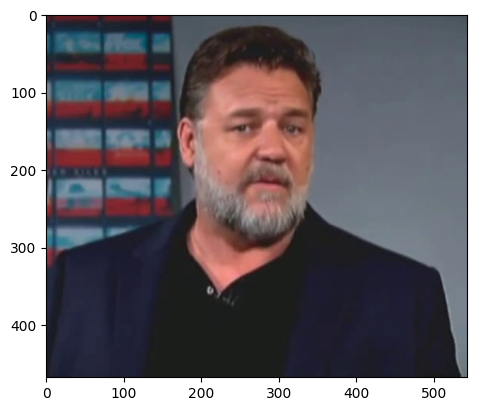

In [32]:
show_single_image(image)

## Gamma Correction

In [34]:
def gamma_correction(image: np.ndarray, gamma: float = 1.0) -> np.ndarray:
    """Perform gamma correction on provided image.
    
    Args:
        image: OpenCV image.
    
    Returns:
        Image after gamma correction.
    
    """
    rgb_max_value = 255
    look_up_table = np.array(
        [
            int(((i / rgb_max_value) ** (1.0 / gamma)) * rgb_max_value)
            for i in np.arange(0, 256)
        ]
    ).astype("uint8")
    # apply gamma correction using lookup table
    return cv.LUT(image, look_up_table)

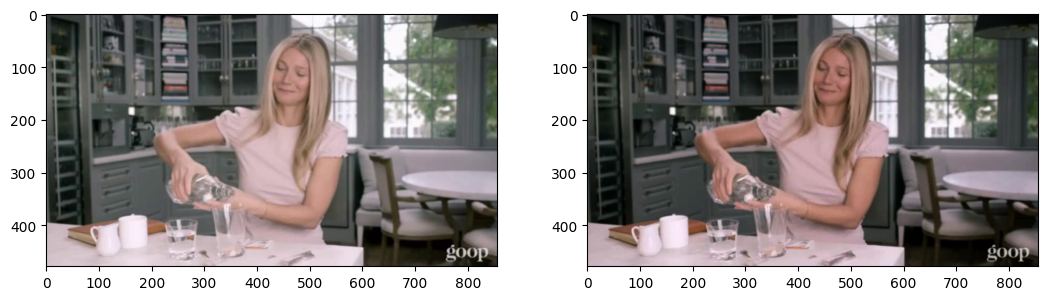

In [52]:
image = read_random_image()
show_single_image_modification(image, gamma_correction, gamma=0.75)

## Histogram Equalization

In [53]:
def histogram_equalization(image: np.ndarray) -> np.ndarray:
    """Perform Histogram Equalization on image.
    
    Equalization is done in YCbCr color space,
    after equalization image is converted back to BGR.
    
    Args:
        image: OpenCV image.
    
    Returns:
        Image after equalization.
    
    """
    # Convert from BGR color space to YCrCb
    ycrcb_image  = cv.cvtColor(image, cv.COLOR_BGR2YCrCb)
    # Eqalize y channel
    ycrcb_image[:, :, 0] = cv.equalizeHist(ycrcb_image[:, :, 0])
    # Convert back to BGR
    return cv.cvtColor(ycrcb_image, cv.COLOR_YCrCb2BGR)

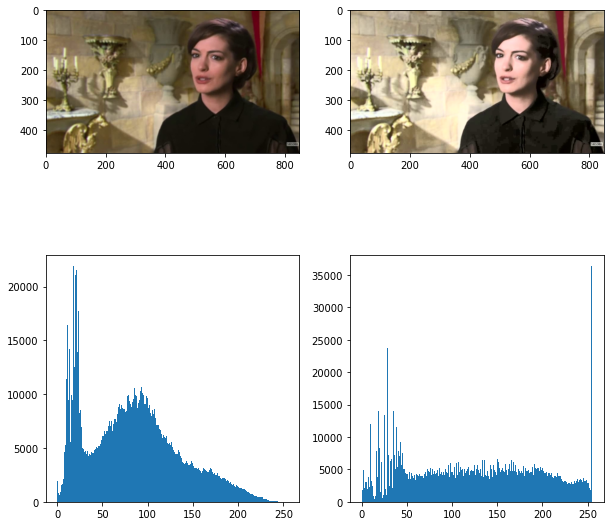

In [10]:
image = read_random_image()
mod_image = histogram_equalization(image)
fig, axes = plt.subplots(2, 2)
fig.set_size_inches(10, 10)
axes[0, 0].imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
axes[0, 1].imshow(cv.cvtColor(mod_image, cv.COLOR_BGR2RGB))
axes[1, 0].hist(image.ravel(), 256, (0, 255))
axes[1, 1].hist(mod_image.ravel(), 256, (0, 255))
plt.show()

## Adaptive histogram equalization

In [41]:
def adaptive_histogram_equalization(image: np.ndarray) -> np.ndarray:
    """Perform Adaptive Histogram Equalization on image.
    
    Equalization is done in YCbCr color space,
    after equalization image is converted back to BGR.
    
    Args:
        image: OpenCV image.
    
    Returns:
        Image after equalization.
    
    """
    # Convert from BGR color space to YCrCb
    ycrcb_image  = cv.cvtColor(image, cv.COLOR_BGR2YCrCb)
    # Prepare CLAHE
    clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    # Eqalize y channel
    ycrcb_image[:, :, 0] = clahe.apply(ycrcb_image[:, :, 0])
    # Convert back to BGR
    return cv.cvtColor(ycrcb_image, cv.COLOR_YCrCb2BGR)

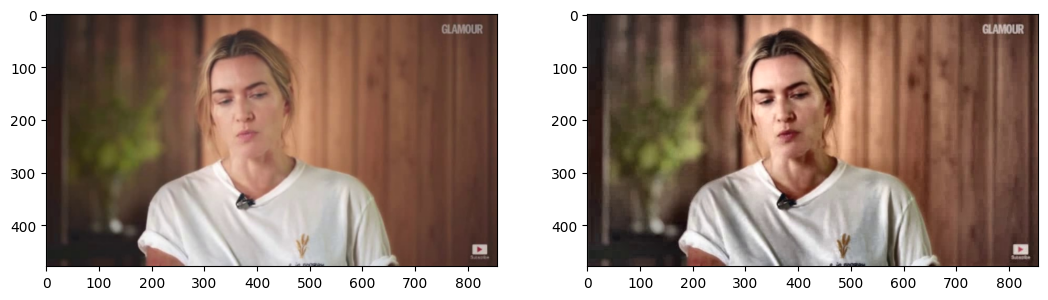

In [42]:
show_single_image_modification(image, adaptive_histogram_equalization)

## Brighness & contrast

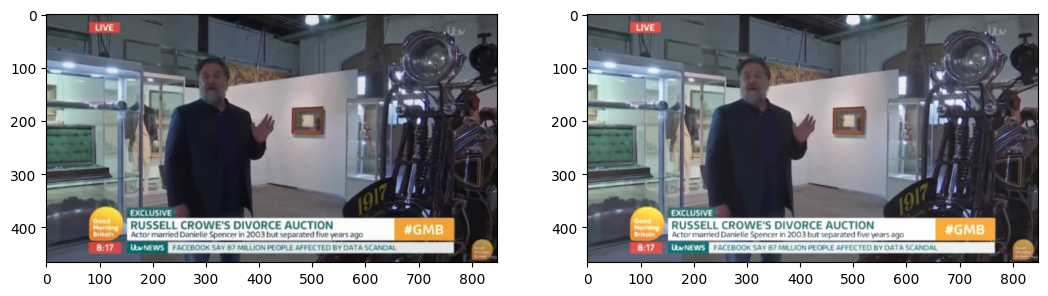

In [16]:
image = read_random_image()
show_single_image_modification(image, cv.convertScaleAbs, alpha=1.0, beta=10)

In [19]:
# Automatic brightness and contrast optimization with optional histogram clipping
def correct_brightness_and_contrast(image: np.ndarray, clip_hist_percent=1):
    gray_image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)

    # Calculate grayscale histogram
    hist = cv.calcHist([gray_image], [0], None, [256], [0, 256])
    hist_size = len(hist)

    # Calculate cumulative distribution from the histogram
    accumulator = []
    accumulator.append(float(hist[0]))
    for index in range(1, hist_size):
        accumulator.append(accumulator[index -1] + float(hist[index]))

    # Locate points to clip
    maximum = accumulator[-1]
    clip_hist_percent *= (maximum / 100.0)
    clip_hist_percent /= 2.0

    # Locate left cut
    minimum_gray = 0
    while accumulator[minimum_gray] < clip_hist_percent:
        minimum_gray += 1

    # Locate right cut
    maximum_gray = hist_size -1
    while accumulator[maximum_gray] >= (maximum - clip_hist_percent):
        maximum_gray -= 1

    # Calculate alpha and beta values
    alpha = 255 / (maximum_gray - minimum_gray)
    beta = -minimum_gray * alpha

    # Calculate new histogram with desired range and show histogram
    """
    new_hist = cv.calcHist([gray_image],[0],None,[256],[minimum_gray,maximum_gray])
    plt.plot(hist)
    plt.plot(new_hist)
    plt.xlim([0,256])
    plt.show()
    """
    return cv.convertScaleAbs(image, alpha=alpha, beta=beta)
    

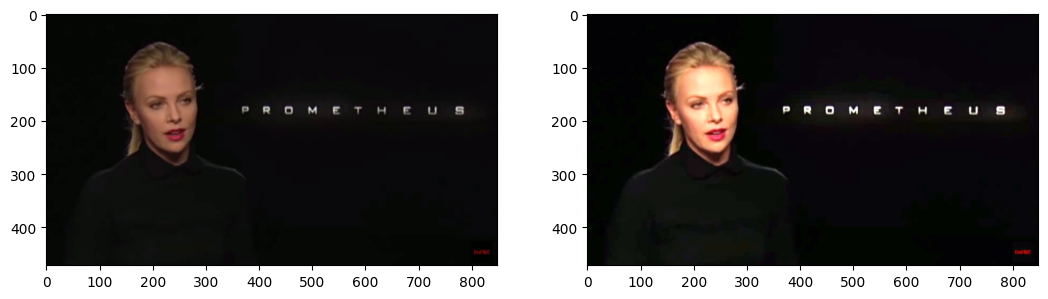

In [21]:
image = read_random_image()
show_single_image_modification(image, correct_brightness_and_contrast, clip_hist_percent=1)

## Red effect removal
Using dlib face detector
1. Find eyes
2. Find pupils via mask?

In [15]:
@dataclasses.dataclass
class Rectangle:
    """Rectangle representations.
    
    Args:
        x: horizontal coordinates of rectangle left upper corner
        y: vertival coordinates of rectangle left upper corner
        width: rectangle width
        height: rectangle height

    """
    x: int
    y: int
    width: int
    height: int

In [16]:
@functools.lru_cache(maxsize=1)
def _load_dlib_face_detector():
    return dlib.get_frontal_face_detector()

@functools.lru_cache(maxsize=1)
def _load_dlib_face_landmarks_detector(
    detector_path: str = "/media/cicheck/Extreme Pro/models/shape_predictor_68_face_landmarks.dat"
):
    return dlib.shape_predictor(detector_path)


In [17]:
def convert_dlib_shape_to_np_array(dlib_shape):
    """Convert dlib shape into numpy array:
    
        Args:
            dlib_shape: dliib shape, e.g. output of dlib shape predicator
        
        Returns:
            numpy array containing points from provided shape
    
    """
    return np.array(
        [[point.x, point.y] for point in dlib_shape.parts()],
        dtype="int"
    )

In [24]:
def _create_eye_mask(eye_landmarks, image_shape):
    convex_hull = cv.convexHull(eye_landmarks)
    mask = np.zeros(image_shape, np.uint8)
    mask = cv.drawContours(mask, np.array([np.squeeze(convex_hull)]), -1, (255,255,255), cv.FILLED)
    mask = cv.cvtColor(mask, cv.COLOR_BGR2GRAY)
    return mask

def _add_red_eye_effect_to_single_eye(image: np.ndarray, eye_landmarks) -> np.ndarray:
    eye_mask = _create_eye_mask(eye_landmarks, image.shape)
    min_channel = np.amin(image, axis=2)
    brightness_threshold = 50
    is_lower_than_treshold = min_channel < brightness_threshold
    is_eye_pixel = eye_mask == 255
    is_pupil = is_eye_pixel & is_lower_than_treshold
    addition = 255 - min_channel
    modified_image = image.copy()
    modified_image[is_eye_pixel & is_pupil, 2] =  addition[is_eye_pixel & is_pupil]
    return modified_image
    

def add_red_eye_effect(image: np.ndarray) -> np.ndarray:
    """Add red-eye effect to provided image.
    
    Args:
        image: OpenCV image.
    
    Returns:
        Image with red-eye effet added.
    
    """
    face_detector = _load_dlib_face_detector()
    landmark_detector = _load_dlib_face_landmarks_detector()
    gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    faces = face_detector(gray, 1)
    face = faces[0]
    shape = landmark_detector(gray, face)
    landmarks = convert_dlib_shape_to_np_array(shape)
    # Select eyes landmarks
    left_eye_landmakrs = landmarks[36:42]
    right_eye_landmarks = landmarks[42:48]
    modified_image = _add_red_eye_effect_to_single_eye(image, left_eye_landmakrs)
    modified_image = _add_red_eye_effect_to_single_eye(modified_image, right_eye_landmarks)
    return modified_image
    

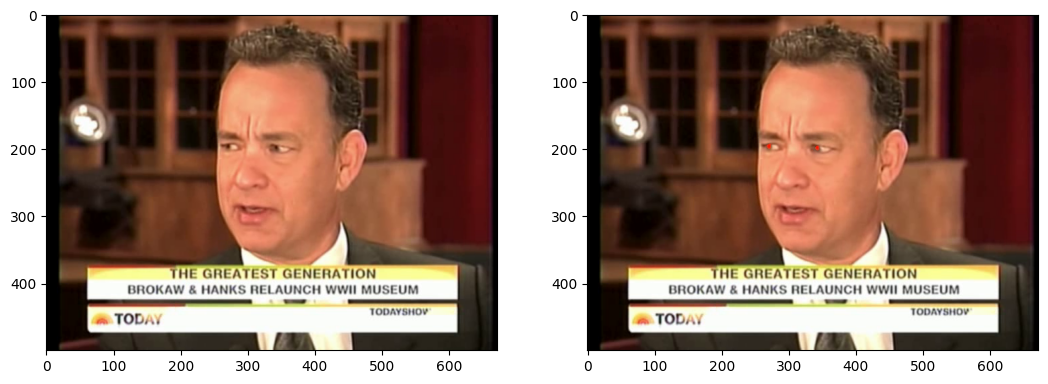

In [25]:
image = read_random_image()
show_single_image_modification(image, add_red_eye_effect)

## Gaussian blur (AKA Gaussian smoothing)

In [21]:
def apply_gaussian_blur(
    image: np.ndarray,
    kernel_size: t.Optional[t.Tuple[int, int]] = (5, 5),
    sigma_x: int = 0,
    sigma_y: int = 0,
) -> np.ndarray:
    """Apply Gaussian blur to provided image.
    
    Args:
        image: OpenCV image.
        kernel_size: Gaussian kernel size used by OpenCV, it needs to be a pair of odd ints,
            or zeros if sigma values should be used to compute kernel automaticly.
        sigma_x: Gaussian kernel standard deviation in X direction used by OpenCV.
        sigma_y: Gaussian kernel standard deviation in Y direction used by OpenCV.
    
    Returns:
        Image after applying Gaussian blur.
    
    """
    return cv.GaussianBlur(image, ksize=kernel_size, sigmaX = sigma_x, sigmaY = sigma_y)
    

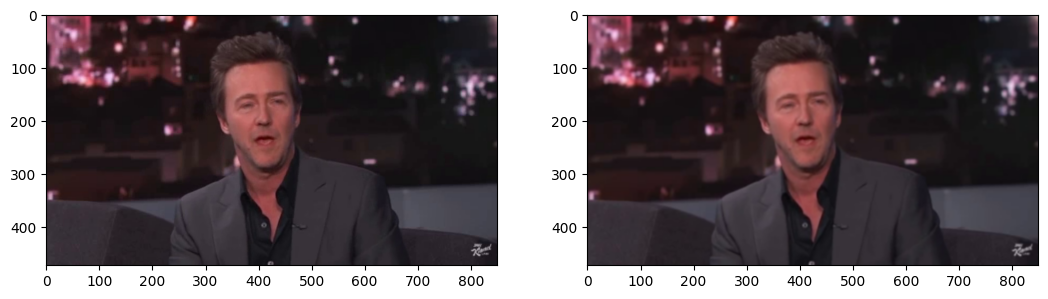

In [22]:
image = read_random_image()
show_single_image_modification(image, apply_gaussian_blur)

## Median filter

In [25]:
def apply_median_filter(
    image: np.ndarray,
    aperture_size: int = 5,
) -> np.ndarray:
    """Apply Median blur to provided image.
    
    Args:
        image: OpenCV image.
        aperture: aperture size used by OpenCV, must be odd integer.
    
    Returns:
        Image after applying Gaussian blur.
    
    """
    return cv.medianBlur(image, ksize=aperture_size)

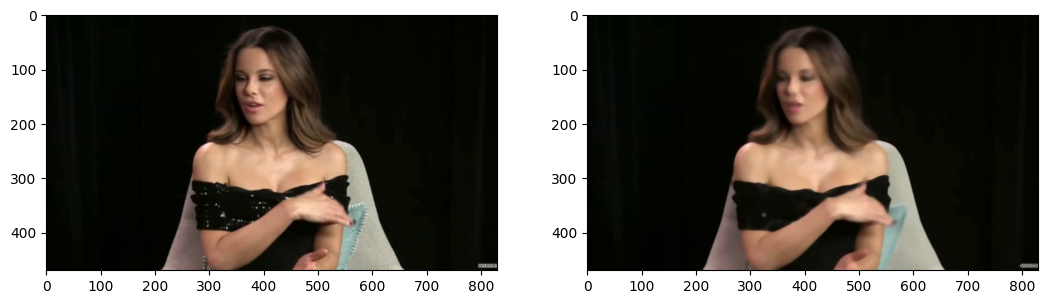

In [34]:
image = read_random_image()
show_single_image_modification(image, apply_median_filter, aperture_size=9)